In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from sklearn.calibration import calibration_curve

# --- CONFIG ---
PF_SERVER_URL = "http://localhost:1000/analyze"
MAX_SAMPLES = 500

# --- HELPER FUNCTIONS ---
def parse_label(value):
    if isinstance(value, int): return value
    if isinstance(value, str):
        v = value.lower()
        if v in ["jailbreak", "malicious", "unsafe", "attack", "injection", "1"]: return 1
        if v in ["benign", "safe", "legit", "0"]: return 0
    try: return int(value)
    except: return 0

def get_pf_prediction(text):
    """
    Uses the same logic as your working accuracy benchmark.
    Returns (pred_label, prob_malicious)
    """
    try:
        resp = requests.post(PF_SERVER_URL, json={"prompt": text}, timeout=5)
        resp.raise_for_status()
        data = resp.json()

        # Use the boolean flag your server actually returns
        pred_label = int(data.get("is_malicious", 0))

        # Use the confidence if present; otherwise fallback
        conf = data.get("confidence")
        if conf is None:
            # Fallback: treat prediction as certain
            prob_malicious = 1.0 if pred_label == 1 else 0.0
        else:
            # Align probability with class 1
            prob_malicious = conf if pred_label == 1 else 1 - conf

        return pred_label, prob_malicious

    except Exception as e:
        print(f"Request failed for text: {text[:30]}... -> {e}")
        return 0, 0.5

# --- DATASET & INFERENCE ---
ds = load_dataset("qualifire/prompt-injections-benchmark", split="test")
ds = ds.shuffle(seed=42).select(range(min(len(ds), MAX_SAMPLES)))

results = []
print("Running PromptForest calibration...")

for ex in tqdm(ds):
    text = ex.get("text") or ex.get("prompt")
    if not text: continue

    label = parse_label(ex["label"])
    pred_label, prob_malicious = get_pf_prediction(text)

    # Confidence of the predicted class
    confidence = prob_malicious if pred_label == 1 else 1 - prob_malicious

    results.append({
        "label": label,
        "prediction": pred_label,
        "prob_malicious": prob_malicious,
        "confidence": confidence,
        "is_correct": pred_label == label
    })

df = pd.DataFrame(results)

# --- ANALYSIS ---
print(f"\nTotal Samples: {len(df)}")
print(f"Accuracy: {df['is_correct'].mean():.4f}")

# Overconfidence on wrong predictions
wrong_df = df[~df['is_correct']]
avg_conf_wrong = wrong_df["confidence"].mean() if not wrong_df.empty else 0
print(f"Avg Confidence on WRONG answers: {avg_conf_wrong:.4f}")

# ECE calculation
probs = np.array(df["prob_malicious"])
labels = np.array(df["label"])
prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)

# Weighted ECE approximation
ece = np.mean(np.abs(prob_true - prob_pred))
print(f"Approximate ECE: {ece:.4f}")

# Plot reliability diagram
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="x", color="orange", label="PromptForest")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title(f"Reliability Diagram (ECE ≈ {ece:.3f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Running qualifire/prompt-injections-benchmark


100%|██████████| 500/500 [01:01<00:00,  8.10it/s]



Accuracy per dataset:
                                 dataset  accuracy
0  qualifire/prompt-injections-benchmark     0.802
Overall accuracy: 0.802


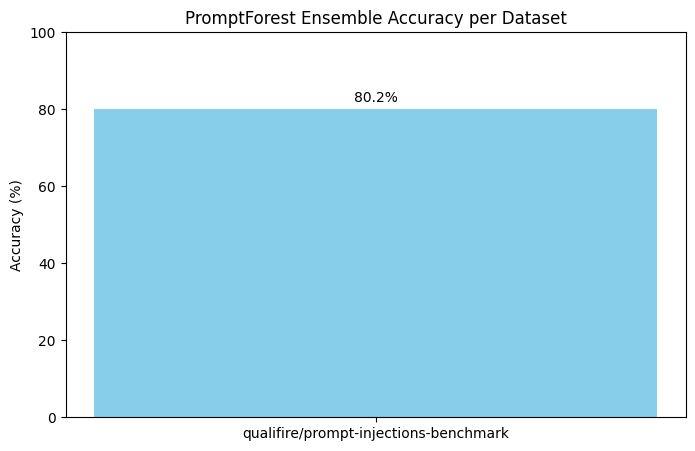

In [4]:
plt.figure(figsize=(8, 5))
plt.bar(accuracy_df['dataset'], accuracy_df['accuracy']*100, color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("PromptForest Ensemble Accuracy per Dataset")
for i, acc in enumerate(accuracy_df['accuracy']*100):
    plt.text(i, acc + 1, f"{acc:.1f}%", ha='center', va='bottom')
plt.show()